<a href="https://colab.research.google.com/github/Celeste1221/ColorStyleTransfer/blob/main/CF_13_1_ColorStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Code modified from: https://www.tensorflow.org/tutorials/generative/style_transfer

In [ ]:
%pip install --upgrade imageio
%pip install --upgrade scikit-image
%pip install ipywidgets

In [1]:
import os
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [51]:
# Image processing functions

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
# Define a function to load an image and limit its max dims to 512 pixels
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [69]:
# load style image
style_path = 'notredame.jpg'
# loat content image
content_path = 'winterserious.jpg'
print(content_path)

winterserious.jpg


In [ ]:
# correct the colors of the output to maintain the colors of the content image
output = 'color_shift.jpg'
orgcontent = content_path
cp = 'match'

%run -i lum-transfer-indents-fixed.py --content_image {content_path} --style_image {style_path} --output_image {output} \
--output_style_image {output} --org_content {orgcontent} --cp_mode {cp}

In [71]:
# to use the color correction code above
style_path_with_cc = output

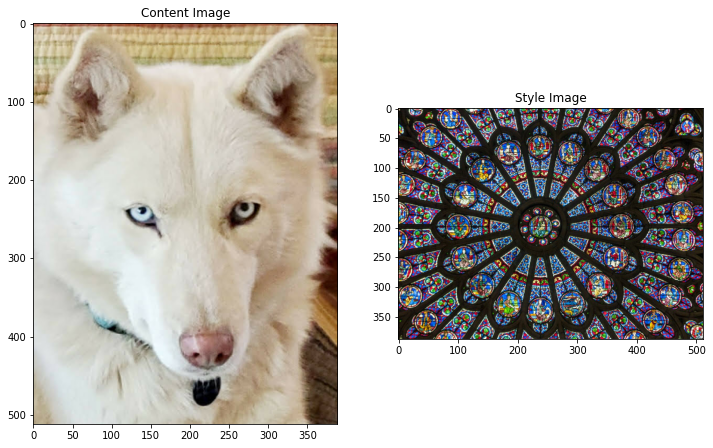

In [72]:
content_image = load_img(content_path)
# load image without color correction to use the colors of the style image (in this case, stained glass) 
style_image = load_img(style_path)
# load image with color correction (cc) to preserve colors of content image 
# style_image = load_img(style_path_with_cc) 

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [73]:
# load a `VGG19` architecture and weights without the classification head, to get the intermediate layers, and list the layer names
# the intermediate layers represent the style and content of the images
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
print()
for layer in vgg.layers:
  print(layer.name)


input_9
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [74]:
# Choose intermediate layers from the network to represent the style and content of the image:

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [75]:
# Build a VGG19 model that returns a list of intermediate layer outputs
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [76]:
# And to create the model:
style_extractor = vgg_layers(style_layers) # model
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 387, 511, 64)
  min:  0.0
  max:  834.5499
  mean:  32.045174

block2_conv1
  shape:  (1, 193, 255, 128)
  min:  0.0
  max:  5217.2593
  mean:  226.94226

block3_conv1
  shape:  (1, 96, 127, 256)
  min:  0.0
  max:  11915.377
  mean:  280.27664

block4_conv1
  shape:  (1, 48, 63, 512)
  min:  0.0
  max:  23513.486
  mean:  971.8412

block5_conv1
  shape:  (1, 24, 31, 512)
  min:  0.0
  max:  3678.5823
  mean:  83.26449



In [77]:
# Calculate a Gram Matrix to get the values of the intermediate feature maps (i.e. the content)
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [78]:
# Build a model that returns the style and content tensors.
class StyleContentModel(tf.keras.models.Model): 
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [79]:
# When called on an image, this model returns the gram matrix (style) of the style_layers
# and content of the content_layers
extractor = StyleContentModel(style_layers, content_layers) # model

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.010652764
    max:  66543.78
    mean:  228.99226

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  74841.63
    mean:  7197.7993

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  210101.23
    mean:  6072.329

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1727021.4
    mean:  111871.88

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  64133.58
    mean:  1084.9508

Contents:
   block5_conv2
    shape:  (1, 32, 24, 512)
    min:  0.0
    max:  1262.3975
    mean:  12.520841


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

In [80]:
# Set your style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [81]:
# Define a `tf.Variable` to contain the image to optimize. To make this quick, 
#initialize it with the content image (the `tf.Variable` must be the same shape as the content image):
image = tf.Variable(content_image)

In [82]:
# Since this is a float image, define a function to keep the pixel values between 0 and 1:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [83]:
# To optimize this, use a weighted combination of the two losses to get the total loss:
style_weight=1e-2
content_weight=1e4

In [84]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [85]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
  return x_var, y_var

In [30]:
tf.image.total_variation(image).numpy()

array([15127.475], dtype=float32)

In [86]:
# Choose a weight for the `total_variation_loss` and include it in the train_step function:
total_variation_weight=30
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [87]:
# Initialize the image-variable and the optimizer:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

## Run the optimization

In [91]:
# Run the optimization
import time
start = time.time()

epochs = 100
steps_per_epoch = 64

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  # display.clear_output(wait=True)
  # display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

................................................................Train step: 64
................................................................Train step: 128
................................................................Train step: 192
................................................................Train step: 256
................................................................Train step: 320
................................................................Train step: 384
................................................................Train step: 448
................................................................Train step: 512
................................................................Train step: 576
................................................................Train step: 640
................................................................Train step: 704
................................................................Train step: 768
.........................................

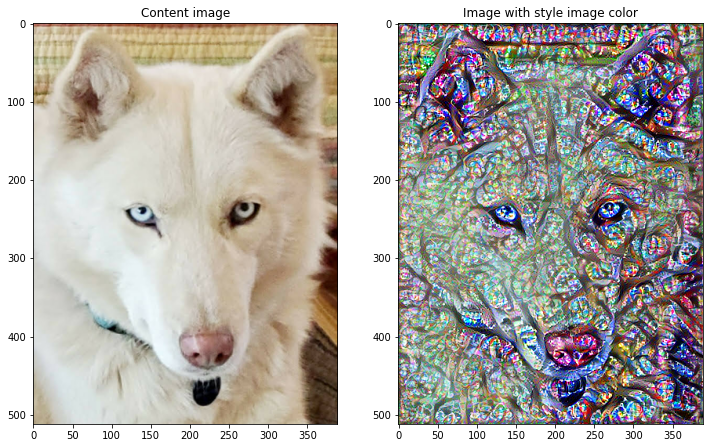

In [89]:
# display original and stylized image without color correction with 10 epochs and 64 steps per epoch

plt.subplot(1,2,1)
imshow(content_image, 'Content image')
plt.subplot(1,2,2)
imshow(image, 'Image with style image color')

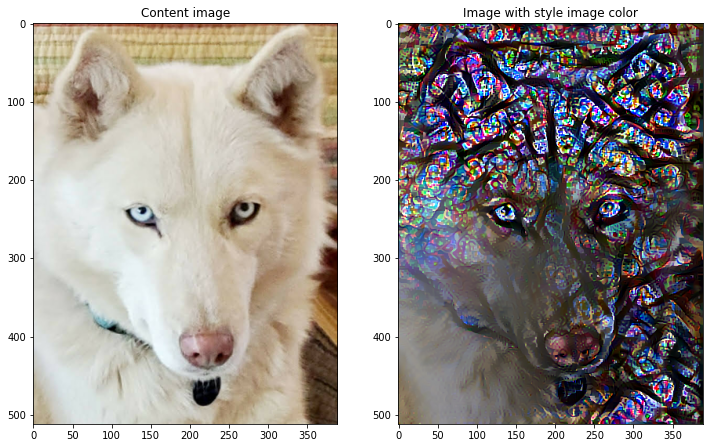

In [92]:
# display original and stylized image without color correction with 100 epochs and 64 steps per epoch
plt.subplot(1,2,1)
imshow(content_image, 'Content image')
plt.subplot(1,2,2)
imshow(image, 'Image with style image color')

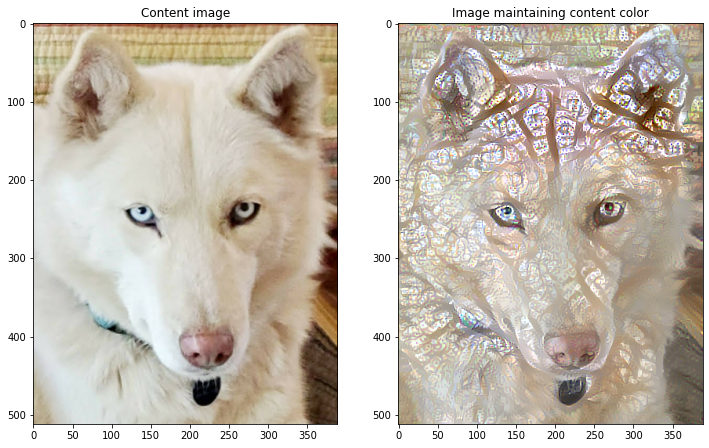

In [43]:
# display original and stylized image with color correction; 10 epochs, 100 steps per epoch
plt.subplot(1,2,1)
imshow(content_image, 'Content image')
plt.subplot(1,2,2)
imshow(image, 'Image maintaining content color')

In [34]:
# save the result if running from colab
file_name = 'stylized-image-stylecolor.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>